# Pruning defense

Prune an EfficientNetv2 model that has been pretrained on the CIFAR-10 dataset.

In [86]:
import copy
import csv
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torchvision.utils import make_grid

In [53]:
from Data import Data

In [54]:
DATASETS_DIR = os.path.join("..", "datasets")
CIFAR_DIR = os.path.join(DATASETS_DIR, "CIFAR10", "cifar-10")

MODEL_NAME = 'efficientnet_v2_s'
WEIGHT_PATH = os.path.join("..", "models", "efficientnet_v2_s_cifar10.pth")

## Load locally stored CIFAR-10

We'll just be using the clean dataset for now.

In [55]:
train_images = os.path.join(CIFAR_DIR, "train", "data.npy")
train_labels = os.path.join(CIFAR_DIR, "train", "labels.npy")
test_images = os.path.join(CIFAR_DIR, "test", "data.npy")
test_labels = os.path.join(CIFAR_DIR, "test", "labels.npy")

cifar_10_dataset= Data(train_images=train_images,train_labels=train_labels,
                     test_images=test_images,test_labels=test_labels)

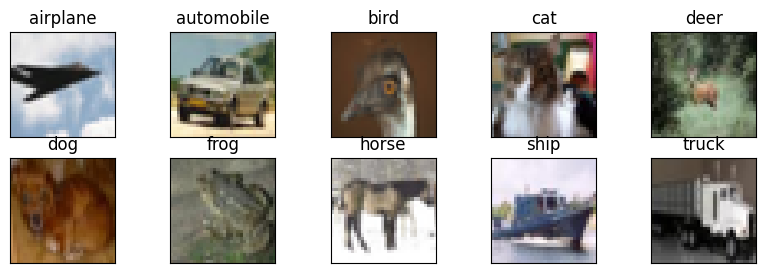

In [5]:
# cifar_10_dataset.normalize()
cifar_10_dataset.show_images()

## Load the pretrained weights

In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torch.hub.load('hankyul2/EfficientNetV2-pytorch', MODEL_NAME, nclass=cifar_10_dataset.num_classes, skip_validation=False)
model.to(device)

state_dict = torch.load(WEIGHT_PATH)
model.load_state_dict(state_dict)


Using cache found in C:\Users\Marko Haralović/.cache\torch\hub\hankyul2_EfficientNetV2-pytorch_main


<All keys matched successfully>

## Visualize activations of ~~the last convolutional layer~~ any layer

> "Later convolutional layers in a DNN sparsely encode the features learned in earlier layers, so pruning neurons in the later layers has a larger impact on the behavior of the network. Consequently, **we prune only the last convolutional layer**..."


In [7]:
def visualize_layer(weights):
    # Only visualize the first out of 24 channels

    grid = make_grid(weights[:,:1,:,:], pad_value=1)
    np_grid = grid.cpu().numpy()

    plt.imshow(np.transpose(np_grid, (1, 2, 0)))
    plt.show()

In [8]:
# Available layers
list(model.state_dict().keys())

['stem.0.weight',
 'stem.1.weight',
 'stem.1.bias',
 'stem.1.running_mean',
 'stem.1.running_var',
 'stem.1.num_batches_tracked',
 'blocks.0.block.fused.0.weight',
 'blocks.0.block.fused.1.weight',
 'blocks.0.block.fused.1.bias',
 'blocks.0.block.fused.1.running_mean',
 'blocks.0.block.fused.1.running_var',
 'blocks.0.block.fused.1.num_batches_tracked',
 'blocks.1.block.fused.0.weight',
 'blocks.1.block.fused.1.weight',
 'blocks.1.block.fused.1.bias',
 'blocks.1.block.fused.1.running_mean',
 'blocks.1.block.fused.1.running_var',
 'blocks.1.block.fused.1.num_batches_tracked',
 'blocks.2.block.fused.0.weight',
 'blocks.2.block.fused.1.weight',
 'blocks.2.block.fused.1.bias',
 'blocks.2.block.fused.1.running_mean',
 'blocks.2.block.fused.1.running_var',
 'blocks.2.block.fused.1.num_batches_tracked',
 'blocks.2.block.fused_point_wise.0.weight',
 'blocks.2.block.fused_point_wise.1.weight',
 'blocks.2.block.fused_point_wise.1.bias',
 'blocks.2.block.fused_point_wise.1.running_mean',
 'blocks

In [9]:
SELECTED_WEIGHT_KEY = 'blocks.0.block.fused.0.weight'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


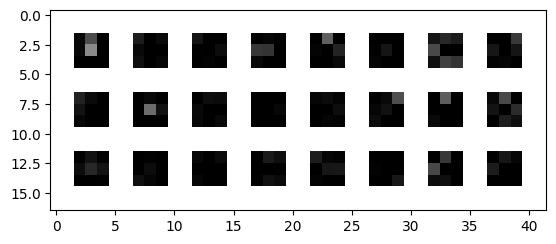

torch.Size([24, 24, 3, 3])

In [10]:
layer_weights = model.state_dict()[SELECTED_WEIGHT_KEY]
visualize_layer(layer_weights)

layer_weights.size()

## Mask neuron [0,0]

#### Test on 3x3 tensor

In [11]:
single_kernel = layer_weights[:1,:1,:3,:3]
single_kernel, single_kernel.size()

(tensor([[[[ 0.0384,  0.2994, -0.0902],
           [ 0.0333,  0.5442, -0.1020],
           [-0.0812, -0.2244, -0.1582]]]], device='cuda:0'),
 torch.Size([1, 1, 3, 3]))

In [12]:
mask = torch.zeros(single_kernel.size()).to(device)
mask

tensor([[[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]]], device='cuda:0')

In [13]:
single_kernel * mask

tensor([[[[0., 0., -0.],
          [0., 0., -0.],
          [-0., -0., -0.]]]], device='cuda:0')

### Apply to entire layer

In [14]:
layer_weights = model.state_dict()[SELECTED_WEIGHT_KEY]
mask = torch.ones(layer_weights.size()).to(device)

mask.size()

torch.Size([24, 24, 3, 3])

In [15]:
mask[0,0,:,:] = 0
mask[0,:2,:,:]

tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]], device='cuda:0')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


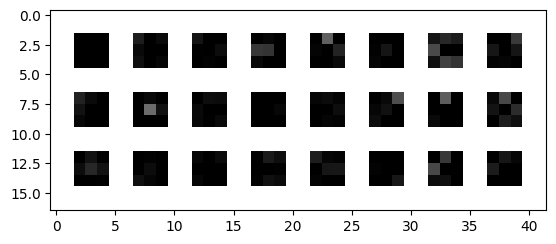

In [16]:
model.state_dict()[SELECTED_WEIGHT_KEY] *= mask

layer_weights = model.state_dict()[SELECTED_WEIGHT_KEY]
visualize_layer(layer_weights)

# Test model on test dataset (measure accuracy) for comparison after pruning 

In [69]:
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
from torchvision import transforms 
from torchvision.transforms import *
from tqdm import tqdm

In [70]:
# Limit dataset size while debugging
TEST_LIMIT = 128
TRAIN_LIMIT = 128
BATCH_SIZE = 8
NUM_WORKERS = 1

In [19]:
cifar_10_dataset.normalize()

In [71]:
test_data = torch.tensor(cifar_10_dataset.test_images, dtype=torch.float32).permute(0, 3, 1, 2)[:TEST_LIMIT]
test_labels = torch.tensor(cifar_10_dataset.test_labels, dtype=torch.long)[:TEST_LIMIT]
test_dataset = TensorDataset(test_data, test_labels)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [73]:
def evaluate_model(model, data_loader, device):
    model.eval()  
    total = 0
    correct = 0
    i = 0
    resize_transform = transforms.Resize((224, 224), antialias=True)

    with torch.no_grad():
        for images, labels in tqdm(data_loader):
            # Resize images here if facing memory issues with whole dataset reshaped at once
            images = torch.stack([resize_transform(img) for img in images])
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            i = i + 1

    accuracy = 100 * correct / total
    return accuracy

In [22]:
accuracy = evaluate_model(model, test_loader, device)
print(f'Test Accuracy: {accuracy}%')


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]

Test Accuracy: 93.75%


## Prune last convolutional layer in Efficient Net and evaluate new model

In [23]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
prune_rate = 0.9

### Prepare validation data

In [74]:
train_data = torch.tensor(cifar_10_dataset.train_images, dtype=torch.float32).permute(0, 3, 1, 2)[:TRAIN_LIMIT]
train_labels = torch.tensor(cifar_10_dataset.train_labels, dtype=torch.long)[:TRAIN_LIMIT]
train_dataset = TensorDataset(train_data, train_labels)

In [75]:
tr_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                               num_workers=NUM_WORKERS ,
                               drop_last=True, pin_memory=True)

### Select layer to prune

In [26]:
LAYER_KEY = 'blocks.39.block.depth_wise.0'

In [27]:
layer_to_prune = None
for name, module in model.named_modules():
    if name == LAYER_KEY:
        layer_to_prune = module
        break

if layer_to_prune is None:
    raise AttributeError("Layer 'blocks.39.block.depth_wise.0' not found in the model")

print("Layer to prune:", layer_to_prune)
print("Weights shape:", layer_to_prune.weight.size())

Layer to prune: Conv2d(1536, 1536, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1536, bias=False)
Weights shape: torch.Size([1536, 1, 3, 3])


### Pruning: 1) Collect outputs of the selected layer

> the defender exercises the DNN received from the attacker with clean inputs from the validation dataset and records the average activation of each neuron

In [28]:
with torch.no_grad():
   container = []

   def forward_hook(module, input, output):
      container.append(output)
   #hook = getattr(model, layer_to_prune).register_forward_hook(forward_hook)
   hook = layer_to_prune.register_forward_hook(forward_hook)

   model.eval()
   for data, _ in tr_loader:
      if device =="cuda":
         model(data.cuda())
      else:
         model(data)

   hook.remove()

print(len(container)) # dataset size
print(container[0].size()) # batch_size x kernel_size_x x kernel_size_y

16
torch.Size([8, 1536, 1, 1])


In [29]:
container_copy = container
container == container_copy

True

### Pruning: 2) Concatenate outputs into single tensor

In [30]:
# Variant A
squeezed_outputs = [torch.squeeze(output) for output in container]
container_squeezed = torch.cat(squeezed_outputs, dim=0)
container_squeezed.size()

torch.Size([128, 1536])

In [31]:
# Variant B
container = torch.cat(container, dim=0)
container.size()

torch.Size([128, 1536, 1, 1])

### Pruning: 3) Calculate the mean output value per neuron and sort them

> The defender then iteratively prunes neurons from the DNN in increasing order of average activations

In [32]:
activation = torch.mean(container, dim=[0, 2, 3])
activation.size()

torch.Size([1536])

In [33]:
seq_sort = torch.argsort(activation) # indices that would sort an array
seq_sort, seq_sort.size()

(tensor([ 904,  503, 1188,  ...,  936, 1224, 1344], device='cuda:0'),
 torch.Size([1536]))

### Pruning: 4) Limit the number of neurones pruned

In [34]:
num_channels = len(activation)
num_channels

1536

In [35]:
prunned_channels = int(num_channels * prune_rate)
prunned_channels

1382

### Pruning: 5) Generate layer mask

In [36]:
mask = torch.ones(layer_to_prune.weight.size()).to(device)

for element in seq_sort[:prunned_channels]:
   mask[element, :, :, :] = 0

mask.size(), mask

(torch.Size([1536, 1, 3, 3]),
 tensor([[[[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]]],
 
 
         [[[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]]],
 
 
         [[[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]]],
 
 
         ...,
 
 
         [[[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]]],
 
 
         [[[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]]],
 
 
         [[[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]]]], device='cuda:0'))

### Pruning: 6) Apply layer mask

In [38]:
model.blocks[39].block.depth_wise[0].weight.data

tensor([[[[ 8.3465e-02,  4.5171e-02,  9.2032e-02],
          [ 2.4224e-02, -7.5739e-03,  3.1552e-02],
          [ 7.8681e-02,  4.0915e-02,  8.4975e-02]]],


        [[[-3.5797e-02, -5.3159e-02, -6.6651e-02],
          [ 6.0911e-02,  8.5260e-02,  5.3053e-02],
          [-4.6339e-02, -4.7214e-02, -3.3129e-02]]],


        [[[ 8.6167e-02,  2.4137e-02,  9.0088e-02],
          [ 2.9598e-02, -2.0199e-03,  2.7803e-02],
          [ 8.6808e-02,  5.8880e-02,  8.5235e-02]]],


        ...,


        [[[ 8.3730e-02,  6.6535e-02,  8.4705e-02],
          [ 1.1458e-02, -2.8791e-02, -4.8533e-03],
          [-6.2923e-02, -7.0896e-02, -6.9237e-02]]],


        [[[-8.1809e-02, -7.8221e-02, -7.7750e-02],
          [-1.7772e-02, -4.5581e-02, -1.5677e-03],
          [ 6.0199e-02,  5.9857e-02,  7.5608e-02]]],


        [[[ 5.3222e-02,  3.8178e-02,  6.7423e-02],
          [ 1.0519e-02, -1.0468e-05,  4.6436e-02],
          [ 7.3146e-02,  5.9901e-02,  1.0503e-01]]]], device='cuda:0')

In [39]:
model.blocks[39].block.depth_wise[0].weight.data *= mask
# layer_to_prune.bias.data *= mask
# layer_to_prune.running_mean *= mask
# layer_to_prune.running_var *= mask

In [40]:
model.blocks[39].block.depth_wise[0].weight.data

tensor([[[[0., 0., 0.],
          [0., -0., 0.],
          [0., 0., 0.]]],


        [[[-0., -0., -0.],
          [0., 0., 0.],
          [-0., -0., -0.]]],


        [[[0., 0., 0.],
          [0., -0., 0.],
          [0., 0., 0.]]],


        ...,


        [[[0., 0., 0.],
          [0., -0., -0.],
          [-0., -0., -0.]]],


        [[[-0., -0., -0.],
          [-0., -0., -0.],
          [0., 0., 0.]]],


        [[[0., 0., 0.],
          [0., -0., 0.],
          [0., 0., 0.]]]], device='cuda:0')

### Evaluate model after pruning

In [41]:
accuracy = evaluate_model(model, test_loader, device)
print(f'Test Accuracy: {accuracy}%')


100%|██████████| 16/16 [00:00<00:00, 16.25it/s]

Test Accuracy: 94.53125%


# Iterative pruning and evaluation
#### Pruning one by one convolutional layer in the 39th layer block of the EfficientNet and evaluating model on test data + visualization

### Step 1: Define all layers to prune in the 39th layer block of the Efficient Net

```
(39): MBConv(
      (block): Sequential(
        (linear_bottleneck): ConvBNAct(
          (0): Conv2d(256, 1536, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(1536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU()
        )
        (depth_wise): ConvBNAct(
          (0): Conv2d(1536, 1536, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1536, bias=False)
          (1): BatchNorm2d(1536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU()
        )
        (se): SEUnit(
          (avg_pool): AdaptiveAvgPool2d(output_size=(1, 1))
          (fc1): Conv2d(1536, 64, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(64, 1536, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (act2): Sigmoid()
        )
        (point_wise): ConvBNAct(
          (0): Conv2d(1536, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): Identity()
        )
      )
      (stochastic_path): StochasticDepth()
    )
```

In [76]:
LAYER_KEYS =[ 'blocks.39.block.depth_wise.0',
               'blocks.39.block.linear_bottleneck.0',
               'blocks.39.block.se.fc1', # ova dva potupno povezana sloja  mola bi biti zeznuta jer se nadovezuju jedan na drugog
               'blocks.39.block.se.fc2',
               'blocks.39.block.point_wise.0'
            ]

In [83]:
CSV_DIR = os.path.join("..", "csv_records")
CSV_PRUNING_DIR = os.path.join(CSV_DIR, "pruning")



In [82]:
layers_to_prune = []
for name, module in model.named_modules():
    if name in LAYER_KEYS:
        layers_to_prune.append(module)

if layers_to_prune is None:
    raise AttributeError("Layers were wrongly named")

for layer_to_prune in layers_to_prune:
    print("Layer to prune:", layer_to_prune)
    print("Weights shape:", layer_to_prune.weight.size())
    print("----------------------------------------------------")

Layer to prune: Conv2d(256, 1536, kernel_size=(1, 1), stride=(1, 1), bias=False)
Weights shape: torch.Size([1536, 256, 1, 1])
----------------------------------------------------
Layer to prune: Conv2d(1536, 1536, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1536, bias=False)
Weights shape: torch.Size([1536, 1, 3, 3])
----------------------------------------------------
Layer to prune: Conv2d(1536, 64, kernel_size=(1, 1), stride=(1, 1))
Weights shape: torch.Size([64, 1536, 1, 1])
----------------------------------------------------
Layer to prune: Conv2d(64, 1536, kernel_size=(1, 1), stride=(1, 1))
Weights shape: torch.Size([1536, 64, 1, 1])
----------------------------------------------------
Layer to prune: Conv2d(1536, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
Weights shape: torch.Size([256, 1536, 1, 1])
----------------------------------------------------


### Step 2: Iterating over prune raates ranging from 0 to 1 and pruning layers, while recording accuracy after each iteration
#### Saving results to a csv file 

In [78]:
prune_rates =  [i/10 for i in range(11)]

In [ ]:
"""
def prune_layer(model, layer_key, prune_rate):
    with torch.no_grad():
        container = []
    def forward_hook(module, input, output):
        container.append(output)
    #hook = getattr(model, layer_to_prune).register_forward_hook(forward_hook)
    hook = layer_to_prune.register_forward_hook(forward_hook)

    model.eval()
    for data, _ in tr_loader:
        if device =="cuda":
            model(data.cuda())
        else:
            model(data)
    hook.remove()
    
    container = torch.cat(container, dim=0)
    activation = torch.mean(container, dim=[0, 2, 3])
    seq_sort = torch.argsort(activation)
    num_channels = len(activation)
    prunned_channels = int(num_channels * prune_rate)
    mask = torch.ones(layer_to_prune.weight.size()).to(device)
    
    for element in seq_sort[:prunned_channels]:
        mask[element, :, :, :] = 0
    model.blocks[39].block.depth_wise[0].weight.data  # TODO: OVO PROMJENITI AN SPECIFICAN SLOJ
    model.blocks[39].block.depth_wise[0].weight.data *= mask

"""

In [105]:
def prune_layer(model, layer_to_prune, prune_rate):
    with torch.no_grad():

        container = []

        def forward_hook(module, input, output):
            container.append(output)
            
        hook = layer_to_prune.register_forward_hook(forward_hook)

        model.eval()
        for data, _ in tr_loader:
            if device == "cuda":
                model(data.cuda())
            else:
                model(data)
                
        hook.remove()

        container = torch.cat(container, dim=0)
        activation = torch.mean(container, dim=[0, 2, 3])
        seq_sort = torch.argsort(activation)
        num_channels = len(activation)
        prunned_channels = int(num_channels * prune_rate)
        
        mask = torch.ones(layer_to_prune.weight.size()).to(device)
        for element in seq_sort[:prunned_channels]:
            mask[element, :, :, :] = 0

        layer_to_prune.weight.data *= mask


In [84]:
os.makedirs(os.path.dirname(CSV_PRUNING_DIR), exist_ok=True)

In [106]:
# original state of the model to go back to after pruning a layer in the following iteration
original_state_dict = copy.deepcopy(model.state_dict())

In [108]:
original_accuracy = evaluate_model(model, test_loader, device)
print(f'Test Accuracy: {original_accuracy}%')

  0%|          | 0/16 [00:00<?, ?it/s]

100%|██████████| 16/16 [00:36<00:00,  2.28s/it]


In [100]:
csv_file_path = "../csv_records/pruning/evaluate_pruning.csv"

In [ ]:
with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['model_name', 'pruning_rate', 'layer_name', 'accuracy'])
    # writer.writerow(['model', 'unpruned', 'N/A', original_accuracy])

    for layer_to_prune in layers_to_prune:
        for rate in prune_rates:
            prune_layer(model, layer_to_prune, rate)
            accuracy = evaluate_model(model, test_loader,device)

            writer.writerow(['model', rate, layer_key, accuracy])

            # restore model parameters
            model.load_state_dict(copy.deepcopy(original_state_dict))

### Step 3: Vizualization of pruning rates vs accuracy for each layer

##### Hasnt been tested  yet

In [110]:
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv(csv_file_path)

for layer_name in df['layer_name'].unique():
    layer_data = df[df['layer_name'] == layer_name]

    # Plot pruning rate vs accuracy
    plt.figure()
    plt.plot(layer_data['pruning_rate'], layer_data['accuracy'], marker='o')
    plt.title(f'Pruning Rate vs Accuracy for {layer_name}')
    plt.xlabel('Pruning Rate')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.show()